In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, lax, jacfwd, jacrev, value_and_grad
from functools import partial
import matplotlib.pyplot as plt

In [2]:
def init_MLP(layers, key, activation=jax.nn.tanh):
    keys = random.split(key, len(layers)-1)
    params = []
    for in_w, out_w, key in zip(layers[:-1], layers[1:], keys):
        w = random.normal(key, (in_w, out_w), dtype=jnp.float32) * jnp.sqrt(2 / (in_w + out_w))
        b = jnp.zeros(out_w, dtype=jnp.float32)
        params.append((w, b))

    def _MLP(params, x):
        for w, b in params[:-1]:
            x = activation(jnp.dot(x, w) + b)
        w, b = params[-1]
        return jnp.dot(x, w) + b

    return params, _MLP


In [3]:
seed = 0
key = random.PRNGKey(seed)
layers = [1, 128, 128, 1]
params, mlp = init_MLP(layers, key)
jax.tree_map(lambda x: x.shape, params)

[((1, 128), (128,)), ((128, 128), (128,)), ((128, 1), (1,))]

In [4]:
laplace_operator = vmap(jacfwd(jacfwd(mlp, argnums=1), argnums=1), in_axes=(None, 0))
forward = vmap(mlp, in_axes=(None, 0))

def loss_boundary(params, x, y):
    u = forward(params, x)
    return jnp.mean((u - y)**2)

def loss_residual(params, x, y):
    laplace = laplace_operator(params, x)[:, 0, 0]
    return jnp.mean((laplace - y)**2)

def loss_total(params, x_colloc, x_bndry, y_colloc, y_bndry):
    return loss_boundary(params, x_bndry, y_bndry) + loss_residual(params, x_colloc, y_colloc)

@jit
def update(params, opt_state, lr, momentum, x_colloc, x_bndry, y_colloc, y_residual):
    loss, grads = value_and_grad(loss_total)(params, x_colloc, x_bndry, y_colloc, y_residual)
    opt_state = jax.tree_map(lambda avg_g, g: momentum * avg_g + (1 - momentum) * g, opt_state, grads)
    new_params = jax.tree_map(lambda p, g: p - lr * g, params, opt_state)
    # print(grads)
    return new_params, opt_state, loss
        

In [5]:
x_colloc = jnp.linspace(0, 1, 1000, dtype=jnp.float32).reshape(-1, 1)
y_colloc = -(jnp.pi * 4.) ** 2 * jnp.sin(jnp.pi * 4. * x_colloc)
u_exact = jnp.sin(jnp.pi * 4. * x_colloc)
x_bndry = jnp.array([0., 1.], dtype=jnp.float32).reshape(-1, 1)
y_bndry = jnp.zeros((2, 1), dtype=jnp.float32)

In [6]:
# jnp.mean((laplace_operator(params, x_colloc)[:, 0, 0] - y_colloc)**2)

In [7]:
n_epochs = 50000
lr = 1e-4
momentum = 0.99
opt_state = jax.tree_map(lambda x: jnp.zeros_like(x), params)
for epoch in range(n_epochs):
    params, opt_state, loss = update(params, opt_state, lr, momentum, x_colloc, x_bndry, y_colloc, y_bndry)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss:.4f}')
        lr *= 0.95
# for epoch in range(n_epochs):
#     params, loss = update(params, x_colloc, x_bndry, y_colloc, y_bndry)
#     if epoch % 1000 == 0:
#         print(f'Epoch {epoch}, Loss {loss:.4f}')

Epoch 0, Loss 12456.2725
Epoch 1000, Loss 1582.6843
Epoch 2000, Loss 58.9399
Epoch 3000, Loss 50.8795
Epoch 4000, Loss 47.9422
Epoch 5000, Loss 43.9850
Epoch 6000, Loss 37.2567
Epoch 7000, Loss 29.3735
Epoch 8000, Loss 19.9860
Epoch 9000, Loss 7.4553
Epoch 10000, Loss 1.0291
Epoch 11000, Loss 0.2858
Epoch 12000, Loss 0.2369
Epoch 13000, Loss 0.2275
Epoch 14000, Loss 0.2233
Epoch 15000, Loss 0.2205
Epoch 16000, Loss 0.2226
Epoch 17000, Loss 0.2156
Epoch 18000, Loss 0.2185
Epoch 19000, Loss 0.2144
Epoch 20000, Loss 0.2111
Epoch 21000, Loss 0.2115
Epoch 22000, Loss 0.2092
Epoch 23000, Loss 0.2096
Epoch 24000, Loss 0.2085
Epoch 25000, Loss 0.2101
Epoch 26000, Loss 0.2063
Epoch 27000, Loss 0.2052
Epoch 28000, Loss 0.2069
Epoch 29000, Loss 0.2072
Epoch 30000, Loss 0.2045
Epoch 31000, Loss 0.2040
Epoch 32000, Loss 0.2021
Epoch 33000, Loss 0.2035
Epoch 34000, Loss 0.2038
Epoch 35000, Loss 0.2124
Epoch 36000, Loss 0.2123
Epoch 37000, Loss 0.2068
Epoch 38000, Loss 0.2151
Epoch 39000, Loss 0.2159

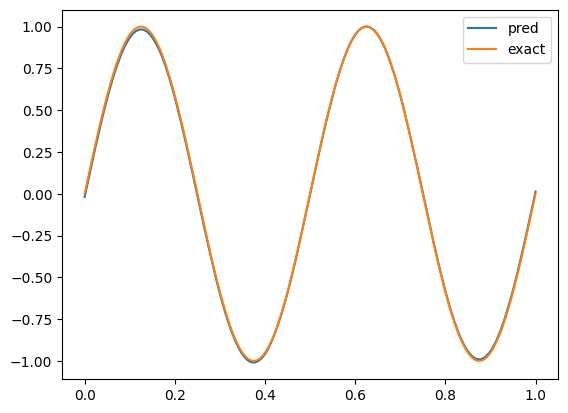

In [9]:
plt.plot(x_colloc, forward(params, x_colloc), label='pred')
plt.plot(x_colloc, u_exact, label='exact')
plt.legend()